# Translating multiomics single-cell data

This tutorial shows how to use the {class}`~moscot.problems.crss_modality.TranslationProblem` for integrating multiomics single-cell data, based on the method wich was firstly introduced in {cite}`demetci-scot:22`.

## Imports and data loading

In [1]:
import warnings

import moscot.plotting as mpl
from moscot.problems.cross_modality import TranslationProblem

import scanpy as sc
import anndata as ad
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pandas as pd

warnings.simplefilter("ignore", UserWarning)

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(


### Dataset description

The datset is from [Simultaneous profiling of transcriptome and chromatin accessibility in single nucleus](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE126074). The data is already dimensionality reduced, namely PCA for gene expression (scRNA-seq) with 10 components and LDA with 19 topics fro chromatin accessibility (snATAC-seq) domain.

In [6]:
adata_atac = sc.read('atac.h5ad')
adata_rna = sc.read('rna.h5ad')
adata_atac, adata_rna

(AnnData object with n_obs × n_vars = 1047 × 19
     obs: 'cluster', 'celltype'
     uns: 'celltype_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_LDA', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'raw'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 1047 × 10
     obs: 'cluster', 'celltype'
     uns: 'celltype_colors', 'neighbors', 'pca', 'umap'
     obsm: 'X_PCA', 'X_pca', 'X_umap'
     varm: 'PCs'
     layers: 'raw'
     obsp: 'connectivities', 'distances')

The dimensions of input datasets are
- ATAC = (1047, 19) -> i.e. 1047 samples belonging to a chromatin accessibility feature space of dimension 19.
- RNA = (1047, 10) -> i.e. 1047 samples belonging to a gene expression feature space of dimension 10.

## Visualization
Visualization of the cell types in the first two principal components of ATAC and RNA before alignment.

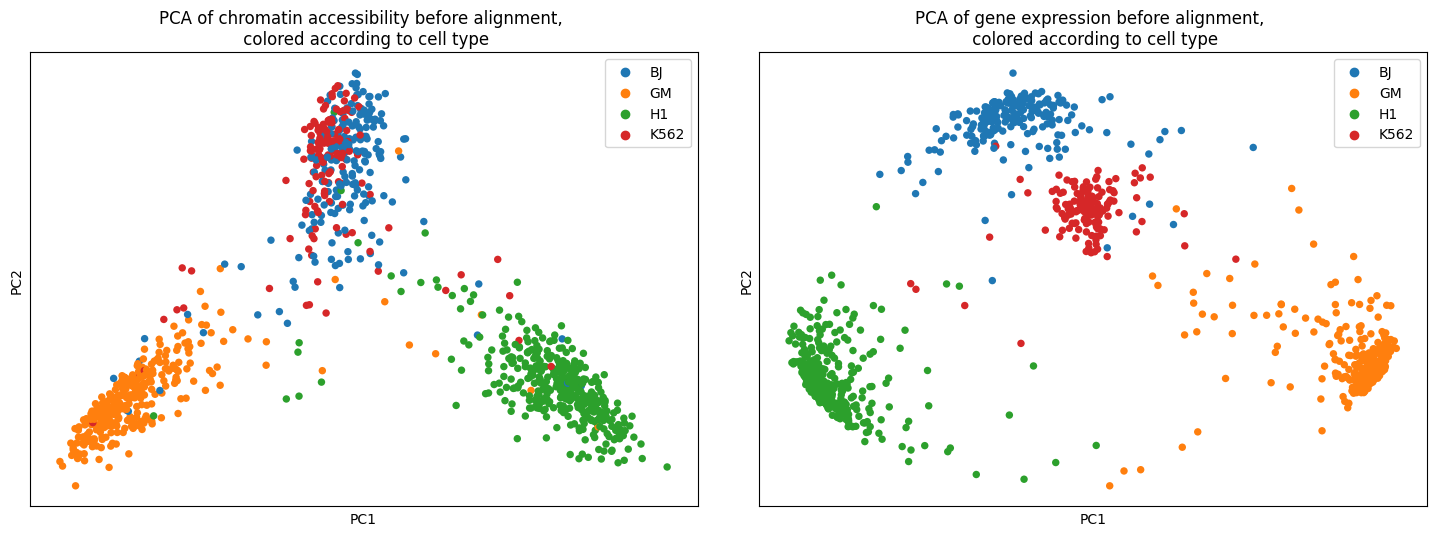

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.pca(adata_atac, color='celltype', ax=ax1, show = False)
ax1.legend()
ax1.set_title(
    "PCA of chromatin accessibility before alignment, \n colored according to cell type"
)
sc.pl.pca(adata_rna, color='celltype', ax=ax2, show = False)
ax2.legend()
ax2.set_title(
    "PCA of gene expression before alignment, \n colored according to cell type"
)
plt.tight_layout(pad=3.0)
plt.show()

## Translating multiomics single-cell data

With {mod}`moscot`, it is possible to learn a cell-to-cell alignment by leveraging Fused Gromov-Wasserstein (FGW) optimal transport.

### Prepare the {class}`~moscot.problems.cross_modality.TranslationProblem`

The moscot {class}`~moscot.problems.cross_modality.TranslationProblem` interfaces the FGW algorithm in a user-friendly API. First, let's initialize the {class}`~moscot.problems.cross_modality.TranslationProblem` by passing source and target {class}`~anndata.AnnData` objects.

In [8]:
tp = TranslationProblem(adata_src=adata_atac, adata_tgt=adata_rna)

After initialization, we need to {meth}`~moscot.problems.space.MappingProblem.prepare` the problem. In this particular case, we need to pay attention to 3 parameters:

- `src_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the source data, for instance ATAC-seq measurements, whose LDA could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `tgt_attr`: specify the attribute in {class}`~anndata.AnnData` that we want to use for the target data, for instance gene expression, whose PCA could be stored for example in {attr}`~anndata.AnnData.obsm`.
- `joint_attr`: it is possible to specify a joint attribut, to take an additional linear term into account.

In [9]:
tp = tp.prepare(
    src_attr={"attr": "obsm", "key": "X_LDA"},
    tgt_attr={"attr": "obsm", "key": "X_PCA"},
    joint_attr = None
)

### Solve the {class}`~moscot.problems.cross_modality.TranslationProblem`

We are now ready to {meth}`~moscot.problems.cross_modality.TranslationProblem.solve` the problem. In fused quadratic problems, the `alpha` parameter defines the convex combination between the quadratic and linear term. Setting `alpha = 1` only considers the quadratic problem, ignoring the `joint_attr`. For the purpose of this example, we'll use `alpha=0.5`. We set `epsilon` to be relatively small to get a sparse mapping between cells.

In [10]:
tp = tp.solve(epsilon=1e-3, alpha=0.5)

INFO     Solving problem OTProblem[stage='prepared', shape=(1047, 1047)].                                          
WARNING  Solver did not converge                                                                                   


### Translate the {class}`~moscot.problems.cross_modality.TranslationProblem`
We can now project one domain onto the other. The boolean paramter `forward` determines the direction of the barycentric projection. In our case, we project the source {class}`~anndata.AnnData` (`ATAC`) onto the target {class}`~anndata.AnnData` (`RNA`), therefore we use `forward = True`. The function {meth}`~moscot.problems.cross_modality.TranslationProblem.translate` returns the translated object in the target space (or source space respectively).

In [11]:
translated = tp.translate(forward=True)

#### Evaluate results
We will use the average FOSCTTM measure implemented below for evaluation (metric used in {cite}`demetci-scot:22`). This measure reports the fraction of samples closer to a sample than its true match (FOSCTTM), averaged over all samples (the smaller the better).

In [12]:
def foscttm(x,y):
    d = scipy.spatial.distance_matrix(x, y)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    fracs = []
    for i in range(len(foscttm_x)):
        fracs.append((foscttm_x[i]+foscttm_y[i])/2)
    return np.mean(fracs).round(4)

In [13]:
print("Average FOSCTTM score for this alignment with ATAC onto RNA is: ", foscttm(adata_rna.obsm['X_PCA'], translated))

Average FOSCTTM score for this alignment with ATAC onto RNA is:  0.2957


#### Visualize translation
For the sake of visualization, we concatenate the translated chromatin accessibility points mapped to gene expression domain to the original gene expression data. Then we plot a PCA of the concatenated data in the gene expression domain, colored according to original domain and cell type.

In [14]:
adata = ad.AnnData(np.concatenate((translated, adata_rna.obsm['X_PCA']), axis = 0))
adata.obs['celltype'] = np.concatenate((adata_atac.obs['celltype'], adata_rna.obs['celltype']))
adata.obs['batch'] = pd.Categorical(np.array(['ATAC','RNA']).repeat(adata_atac.shape[0]))
sc.pp.pca(adata, n_comps=2)

/var/folders/2g/p6n6wfws1hs5tmzl6vvj2dvc0000gn/T/ipykernel_19361/1265797172.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(np.concatenate((translated, adata_rna.obsm['X_PCA']), axis = 0))


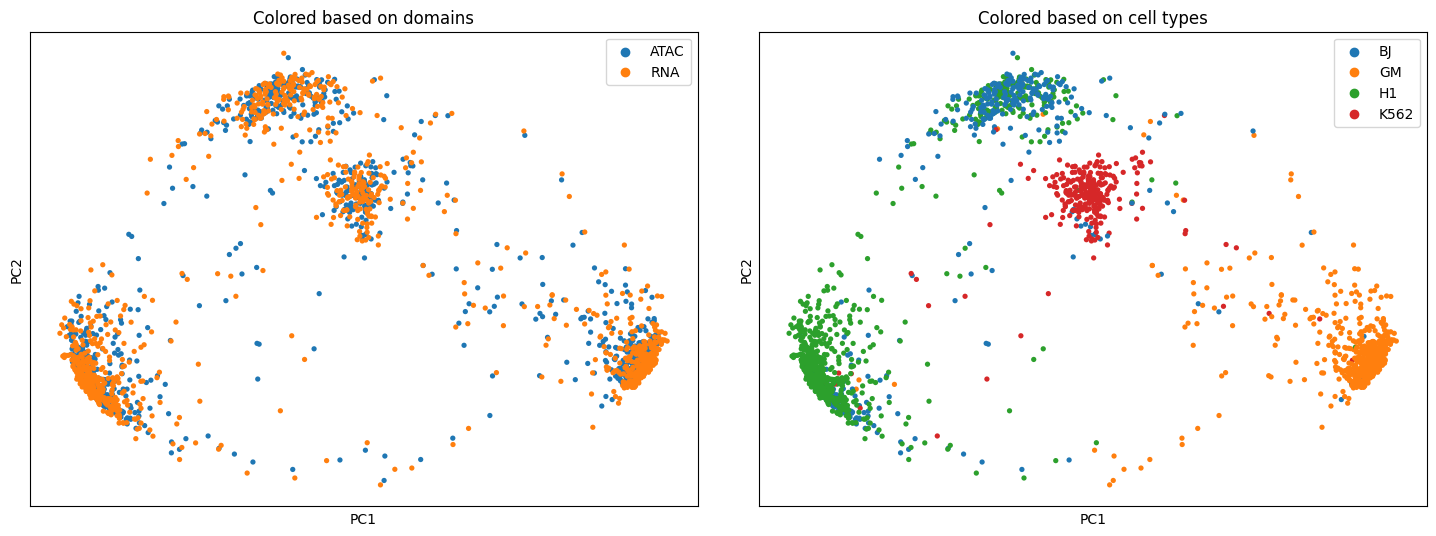

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sc.pl.pca(adata, color = ['batch'], ax=ax1, show = False)
ax1.legend()
ax1.set_title(
    "Colored based on domains"
)
sc.pl.pca(adata, color = ['celltype'], ax=ax2, show = False)
ax2.legend()
ax2.set_title(
    "Colored based on cell types"
)
plt.tight_layout(pad=3.0)
plt.show()

### Analyze cell type transitions
We can now investigate which cell types are mapped where.

/Users/ninasander/anaconda3/envs/moscot_env_1/lib/python3.9/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


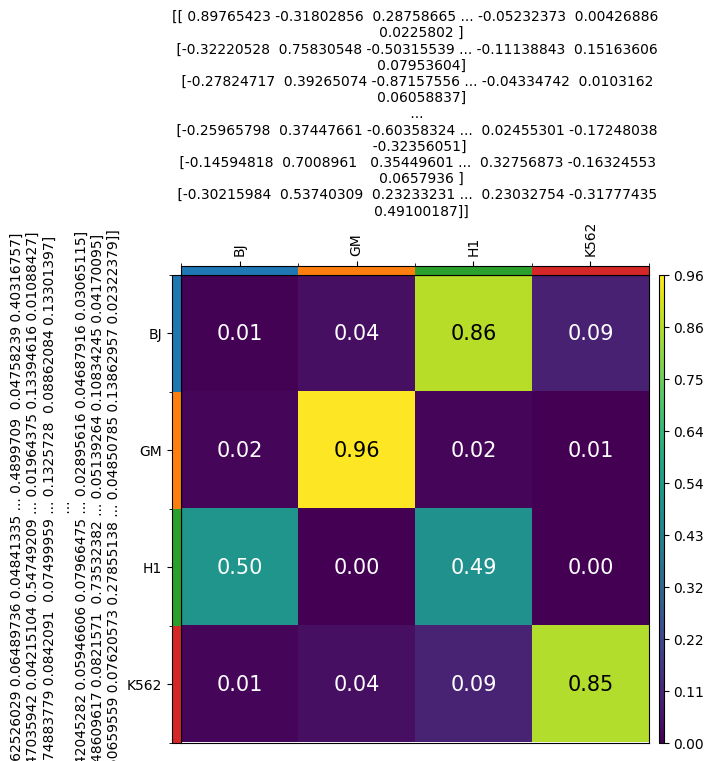

In [16]:
cell_transition = tp.cell_transition(
    source=adata_atac.obsm['X_LDA'], 
    target=adata_rna.obsm['X_PCA'],
    source_groups="celltype",
    target_groups="celltype",
    forward=True,
    )
mpl.cell_transition(tp, fontsize=15, figsize=(5, 5))

The transition matrix shows where cell types from the source object, i.e. chromatin accessibility (corresponding to the rows) are mapped to the targte objects, i.e. gene expression (corresponding to the columns), hence, the rows sum up to 1.